In [1]:
# Importing Libraries
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import pickle
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Base Path for all files
data_dir = '/kaggle/input/plantvillage-dataset/color'

In [3]:
###### Using ImageDataGenerator to load the Images for Training and Testing the CNN Model
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(256, 256),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(256, 256),
                                                     subset='validation',
                                                    ),
}

Found 48888 images belonging to 38 classes.
Found 5417 images belonging to 38 classes.


In [4]:
# Initializing InceptionV3 (pretrained) model with input image shape as (300, 300, 3)
base_model = MobileNetV2(weights=None, include_top=False, input_shape=(256, 256, 3))

# Load Weights for the InceptionV3 Model
base_model.load_weights('../input/tf-keras-pretrained-model-weights/No Top/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_192_no_top.h5')

# Setting the Training of all layers of InceptionV3 model to false
base_model.trainable = False

In [5]:
# Adding some more layers at the end of the Model as per our requirement
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(38, activation='softmax') # 10 Output Neurons for 10 Classes
])

In [6]:
# Using the Adam Optimizer to set the learning rate of our final model
opt = optimizers.Adam(learning_rate=0.0001)

# Compiling and setting the parameters we want our model to use
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [7]:
# Viewing the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_256 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 38)                38950     
Total params: 3,608,678
Trainable params: 1,350,694
Non-trainable params: 2,257,984
_________________________________________________________________


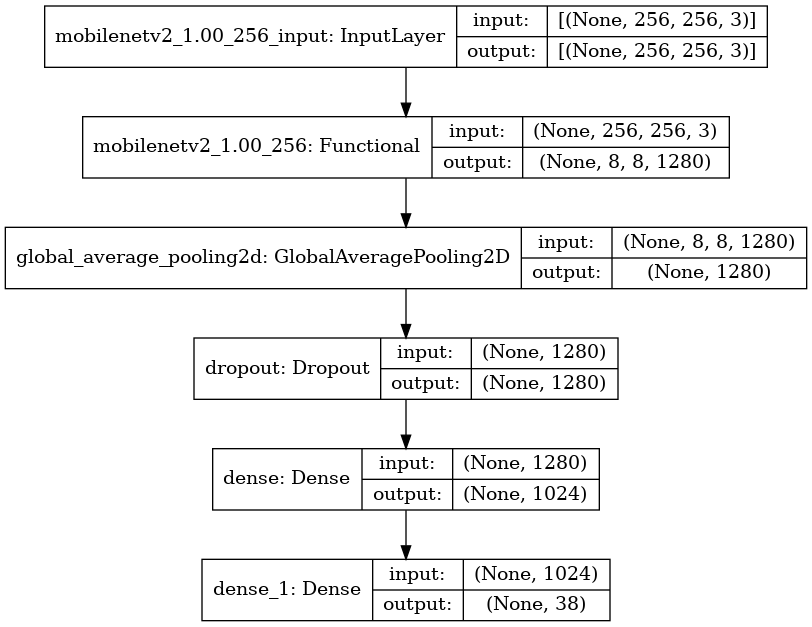

In [8]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [9]:
# Setting variables for the model
batch_size = 40
epochs = 5

# Seperating Training and Testing Data
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [10]:
# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 1222
validation_steps : 135


In [11]:
# File Path to store the trained models
filepath = "./model_{epoch:02d}-{val_accuracy:.2f}.h5"

# Using the ModelCheckpoint function to train and store all the best models
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]
# Training the Model
history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)

Epoch 1/5
1222/1222 [==============================] - 1372s 1s/step - loss: 0.7314 - accuracy: 0.8099 - val_loss: 0.3566 - val_accuracy: 0.8965

Epoch 00001: val_accuracy improved from -inf to 0.89653, saving model to ./model_01-0.90.h5
Epoch 2/5
1222/1222 [==============================] - 1246s 1s/step - loss: 0.3035 - accuracy: 0.9078 - val_loss: 0.2534 - val_accuracy: 0.9241

Epoch 00002: val_accuracy improved from 0.89653 to 0.92407, saving model to ./model_02-0.92.h5
Epoch 3/5
1222/1222 [==============================] - 1240s 1s/step - loss: 0.2547 - accuracy: 0.9194 - val_loss: 0.2248 - val_accuracy: 0.9287

Epoch 00003: val_accuracy improved from 0.92407 to 0.92870, saving model to ./model_03-0.93.h5
Epoch 4/5
1222/1222 [==============================] - 1269s 1s/step - loss: 0.2248 - accuracy: 0.9277 - val_loss: 0.2242 - val_accuracy: 0.9269

Epoch 00004: val_accuracy did not improve from 0.92870
Epoch 5/5
1222/1222 [==============================] - 1224s 1s/step - loss: 0.

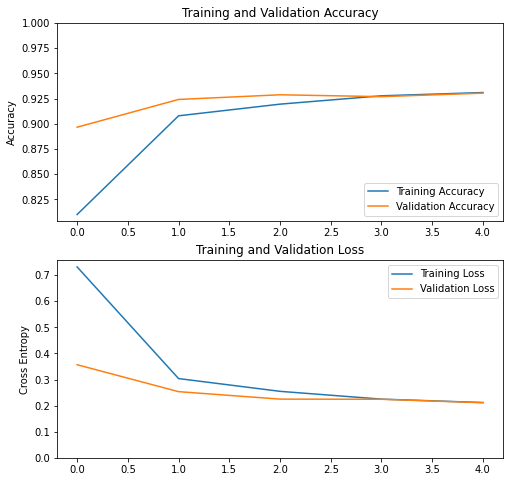

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [13]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

170/170 [==============================] - 82s 483ms/step - loss: 0.2109 - accuracy: 0.9310
test accuracy :  0.930958092212677


In [21]:
# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model("/kaggle/working/model_05-0.93.h5")

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
    img = image.load_img(img_rel_path, target_size=(256, 256))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis, ...])

    # Label array
    labels = {0:'Apple___Apple_scab', 1: 'Apple___Black_rot', 2:'Apple___Cedar_apple_rust', 3:'Apple___healthy', 4:'Background_without_leaves', 5:'Blueberry___healthy', 6:'Cherry___Powdery_mildew', 7:'Cherry___healthy', 8:'Corn___Cercospora_leaf_spot Gray_leaf_spot', 9:'Corn___Common_rust', 10:'Corn___Northern_Leaf_Blight', 11:'Corn___healthy', 12:'Grape___Black_rot', 13:'Grape___Esca_(Black_Measles)', 14:'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 15:'Grape___healthy', 16:'Orange___Haunglongbing_(Citrus_greening)', 17:'Peach___Bacterial_spot', 18:'Peach___healthy', 19:'Pepper,_bell___Bacterial_spot', 20:'Pepper,_bell___healthy', 21:'Potato___Early_blight', 22:'Potato___Late_blight', 23:'Potato___healthy', 24:'Raspberry___healthy', 25:'Soybean___healthy', 26:'Squash___Powdery_mildew', 27:'Strawberry___Leaf_scorch', 28:'Strawberry___healthy', 29:'Tomato___Bacterial_spot', 30:'Tomato___Early_blight', 31:'Tomato___Late_blight', 32:'Tomato___Leaf_Mold', 33:'Tomato___Septoria_leaf_spot', 34:'Tomato___Spider_mites Two-spotted_spider_mite', 35:'Tomato___Target_Spot', 36:'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 37:'Tomato___Tomato_mosaic_virus', 38:'Tomato___healthy'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = labels[np.argmax(p[0], axis=-1)]
    print("Classified:", predicted_class, "\n\n")

    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    def plot_bar_x():
        # this is for plotting purpose
        index = np.arange(len(classes))
        plt.bar(index, prob)
        plt.xlabel('Labels', fontsize=8)
        plt.ylabel('Probability', fontsize=8)
        plt.xticks(index, classes, fontsize=8, rotation=20)
        plt.title('Probability for loaded image')
        plt.show()
    plot_bar_x()

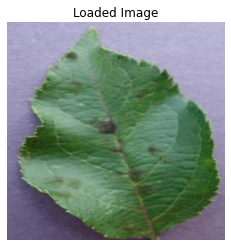



Maximum Probability:  0.98956513
Classified: Apple___Apple_scab 



-------------------Individual Probability--------------------------------

APPLE___APPLE_SCAB : 98.96 %
APPLE___BLACK_ROT : 0.0 %
APPLE___CEDAR_APPLE_RUST : 0.11 %
APPLE___HEALTHY : 0.25 %
BACKGROUND_WITHOUT_LEAVES : 0.0 %
BLUEBERRY___HEALTHY : 0.01 %
CHERRY___POWDERY_MILDEW : 0.0 %
CHERRY___HEALTHY : 0.0 %
CORN___CERCOSPORA_LEAF_SPOT GRAY_LEAF_SPOT : 0.0 %
CORN___COMMON_RUST : 0.0 %
CORN___NORTHERN_LEAF_BLIGHT : 0.0 %
CORN___HEALTHY : 0.0 %
GRAPE___BLACK_ROT : 0.0 %
GRAPE___ESCA_(BLACK_MEASLES) : 0.0 %
GRAPE___LEAF_BLIGHT_(ISARIOPSIS_LEAF_SPOT) : 0.01 %
GRAPE___HEALTHY : 0.0 %
ORANGE___HAUNGLONGBING_(CITRUS_GREENING) : 0.64 %
PEACH___BACTERIAL_SPOT : 0.0 %
PEACH___HEALTHY : 0.0 %
PEPPER,_BELL___BACTERIAL_SPOT : 0.0 %
PEPPER,_BELL___HEALTHY : 0.0 %
POTATO___EARLY_BLIGHT : 0.0 %
POTATO___LATE_BLIGHT : 0.0 %
POTATO___HEALTHY : 0.01 %
RASPBERRY___HEALTHY : 0.0 %
SOYBEAN___HEALTHY : 0.0 %
SQUASH___POWDERY_MILDEW : 0.0 %


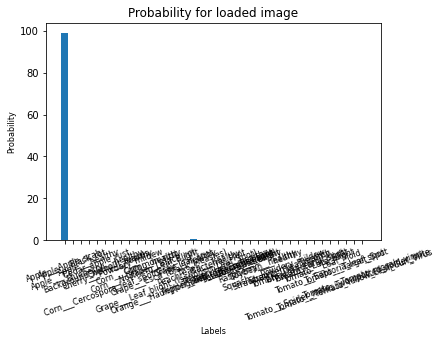

In [22]:
predict("/kaggle/input/plantvillage-dataset/color/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG")